<a href="https://colab.research.google.com/github/dikshapadi/Patch_Pal/blob/main/Isrov2_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [ ]:
!pip install patchify

In [ ]:
from patchify import patchify

In [ ]:
!ls -lah '/content/drive/MyDrive/CollabNotebooks/datasets/tiles-data'

total 33K
-rw------- 1 root root  548 Jun 21 17:55  classes.json
drwx------ 4 root root 4.0K Jun 21 17:56 'Tile 1'
drwx------ 4 root root 4.0K Jun 21 17:56 'Tile 2'
drwx------ 4 root root 4.0K Jun 21 17:56 'Tile 3'
drwx------ 4 root root 4.0K Jun 21 17:56 'Tile 4'
drwx------ 4 root root 4.0K Jun 21 17:56 'Tile 5'
drwx------ 4 root root 4.0K Jun 21 17:56 'Tile 6'
drwx------ 4 root root 4.0K Jun 21 17:56 'Tile 7'
drwx------ 4 root root 4.0K Jun 21 17:56 'Tile 8'


# Satellite image Data Preparation ->

In [ ]:
dataset_root_folder = '/content/drive/MyDrive/CollabNotebooks/datasets'

In [ ]:
dataset_name = 'tiles-data'

In [ ]:
for path, subdir, files in os.walk(dataset_root_folder):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'images':
    images = os.listdir(path) # images is an array of all images
    print(path)
    #for i in images:
      #print(i)

/content/drive/MyDrive/CollabNotebooks/datasets/tiles-data/Tile 5/images
/content/drive/MyDrive/CollabNotebooks/datasets/tiles-data/Tile 8/images
/content/drive/MyDrive/CollabNotebooks/datasets/tiles-data/Tile 4/images
/content/drive/MyDrive/CollabNotebooks/datasets/tiles-data/Tile 2/images
/content/drive/MyDrive/CollabNotebooks/datasets/tiles-data/Tile 3/images
/content/drive/MyDrive/CollabNotebooks/datasets/tiles-data/Tile 1/images
/content/drive/MyDrive/CollabNotebooks/datasets/tiles-data/Tile 6/images
/content/drive/MyDrive/CollabNotebooks/datasets/tiles-data/Tile 7/images


In [ ]:
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 1/images/image_part_001.jpg')
print('Image shape ->',image.shape)

# Defining the patch size
patch_size = 256

# Type of image
print(type(image))


Image shape -> (644, 797, 3)
<class 'numpy.ndarray'>


In [ ]:
image.shape

(644, 797, 3)

In [ ]:
image_patches = patchify(image, (patch_size, patch_size, 3), step= patch_size)

In [ ]:
len(image_patches)

2

In [ ]:
print(image_patches.shape)

(2, 3, 1, 256, 256, 3)


In [ ]:
image_x = image_patches[0,0,:,:]
#image_y =  minmaxscaler.fit_transform(image_x.reshape(-1, image_x.reshape[-1])).reshape(image_x.shape)
image_y = MinMaxScaler().fit_transform(image_x.reshape(-1, image_patches.shape[-1])).reshape(image_x.shape)
image_y[0].shape

(256, 256, 3)

In [ ]:
# New type
type(Image.fromarray(image))

PIL.Image.Image

In [ ]:
# Reading the satellite images
image_dataset = []
mask_dataset = []
for image_type in ['images', 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
    image_extension = 'png'

  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}')
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # ONLY for masks (BGR to RGB)
        size_x = (image.shape[1]//patch_size)*patch_size # modified images size in multiples of patch size
        size_y = (image.shape[0]//patch_size)*patch_size

        image = Image.fromarray(image) # convert to PIL image
        image = image.crop((0,0,size_x, size_y)) # crop it
        #print(image.size[0], image.size[1])

        image = np.array(image) # convert to numpy array

        # Patchification -> Helps in processing large images by breaking them into manageable patches
        patched_images = patchify(image, (patch_size, patch_size, 3), step=patch_size) # stepsize = patch_size means no overlap
        #print(len(patched_images)) # ie, one image cropped into how many patches

        # Normalisation -> Ensures that all patches have pixel values in the same range, improving model performance
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i, j, :, :]  # Select the individual patch
              #print(individual_patched_image.shape)
              individual_patched_image = MinMaxScaler().fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i, j, :, :]  # Select the individual patch
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [ ]:
print(image_dataset[0]) # decimal due to normalised data using MinMaxScaler function

[[[0.78823529 0.76470588 0.74509804]
  [0.88235294 0.85882353 0.83921569]
  [0.94509804 0.90980392 0.89411765]
  ...
  [0.89411765 0.85882353 0.82352941]
  [0.85882353 0.83137255 0.79607843]
  [0.87843137 0.85098039 0.81568627]]

 [[0.88627451 0.8627451  0.84313725]
  [0.99607843 0.97254902 0.95294118]
  [1.         1.         0.98431373]
  ...
  [0.93333333 0.89803922 0.8627451 ]
  [0.92941176 0.90196078 0.86666667]
  [0.95294118 0.91764706 0.88235294]]

 [[0.97254902 0.94509804 0.93333333]
  [1.         0.98823529 0.97647059]
  [1.         1.         0.98431373]
  ...
  [0.93333333 0.89411765 0.86666667]
  [0.92156863 0.89411765 0.85882353]
  [0.90196078 0.86666667 0.83137255]]

 ...

 [[0.88235294 0.8627451  0.86666667]
  [0.81960784 0.80392157 0.8       ]
  [0.7372549  0.73333333 0.71764706]
  ...
  [0.7254902  0.68235294 0.72156863]
  [0.85490196 0.82352941 0.86666667]
  [0.67843137 0.65882353 0.69411765]]

 [[0.76862745 0.75294118 0.74901961]
  [0.79215686 0.77647059 0.77254902]


In [ ]:
print(mask_dataset[0])

[[[132  41 246]
  [132  41 246]
  [132  41 246]
  ...
  [132  41 246]
  [132  41 246]
  [132  41 246]]

 [[132  41 246]
  [132  41 246]
  [132  41 246]
  ...
  [132  41 246]
  [132  41 246]
  [132  41 246]]

 [[132  41 246]
  [132  41 246]
  [132  41 246]
  ...
  [132  41 246]
  [132  41 246]
  [132  41 246]]

 ...

 [[132  41 246]
  [132  41 246]
  [132  41 246]
  ...
  [132  41 246]
  [132  41 246]
  [132  41 246]]

 [[132  41 246]
  [132  41 246]
  [132  41 246]
  ...
  [132  41 246]
  [132  41 246]
  [132  41 246]]

 [[132  41 246]
  [132  41 246]
  [132  41 246]
  ...
  [132  41 246]
  [132  41 246]
  [132  41 246]]]


In [ ]:
# openCV doc says -> whenever we use imdecode(), in case of color images, the decoded images will have the channels stored in BGR order
# while our images are stored in RGB order, Source : https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html
# Hence, we converted BGR to RGB in the previous code snippet in case of masks

In [ ]:
# Convert images to numpy array
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


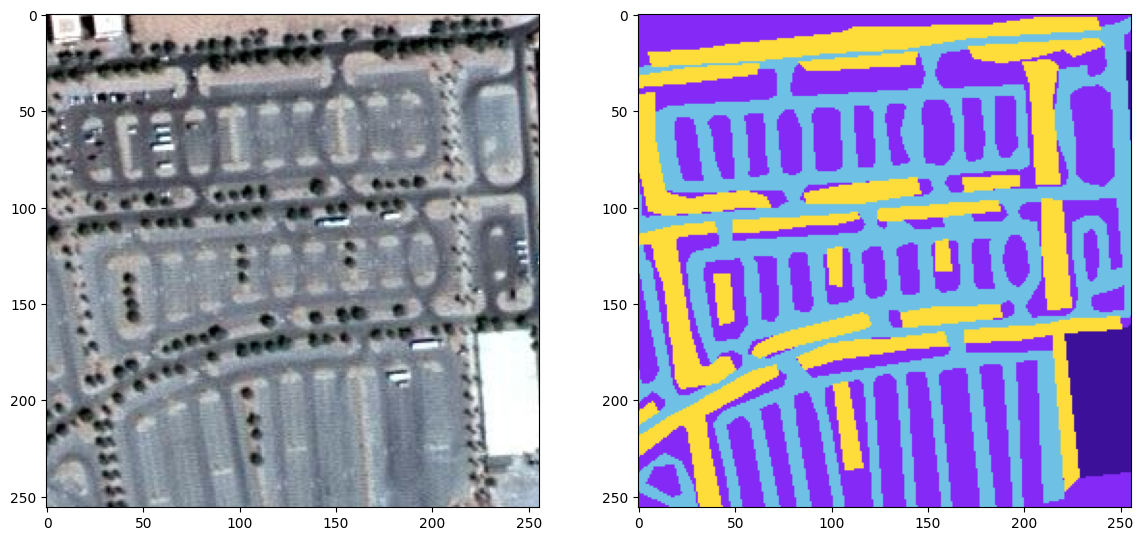

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [ ]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [ ]:
mask_dataset.shape # number of images, size

(945, 256, 256, 3)

In [ ]:
mask_dataset.shape[0]

945

array([[[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       ...,

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]]], dtype=uint8)
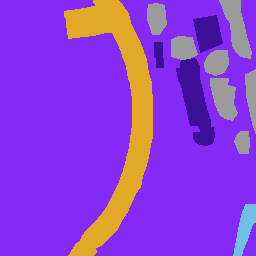

In [ ]:
mask_dataset[0]

In [ ]:
# rgb mask -> single channel label mask

label = individual_patched_mask
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment) # Intermediate label_segment
  label_segment = label_segment[:,:,0] # Final single channel label mask
  print(label_segment)
  return label_segment

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

Streaming output truncated to the last 5000 lines.
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[5 5 5 ... 1 1 1]
 [5 5 5 ... 1 1 1]
 [5 5 5 ... 1 1 1]
 ...
 [0 0 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[0 0 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 

In [ ]:
# Convert to np array
labels = np.array(labels)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
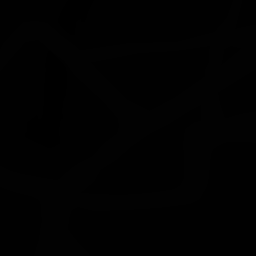

In [ ]:
labels[3]


In [ ]:
labels.shape # represents 945 patches, each patch is 256x256 pixels

(945, 256, 256)

In [ ]:
labels = np.expand_dims(labels, axis = 3) # added one additional dimension

In [ ]:
labels.shape # 1 represents the single channel, so each pixel has a class ID/label now

(945, 256, 256, 1)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
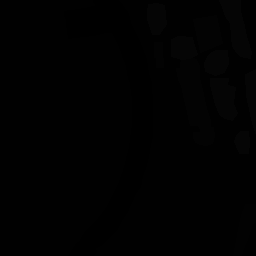

In [ ]:
labels[0][:,:,0]

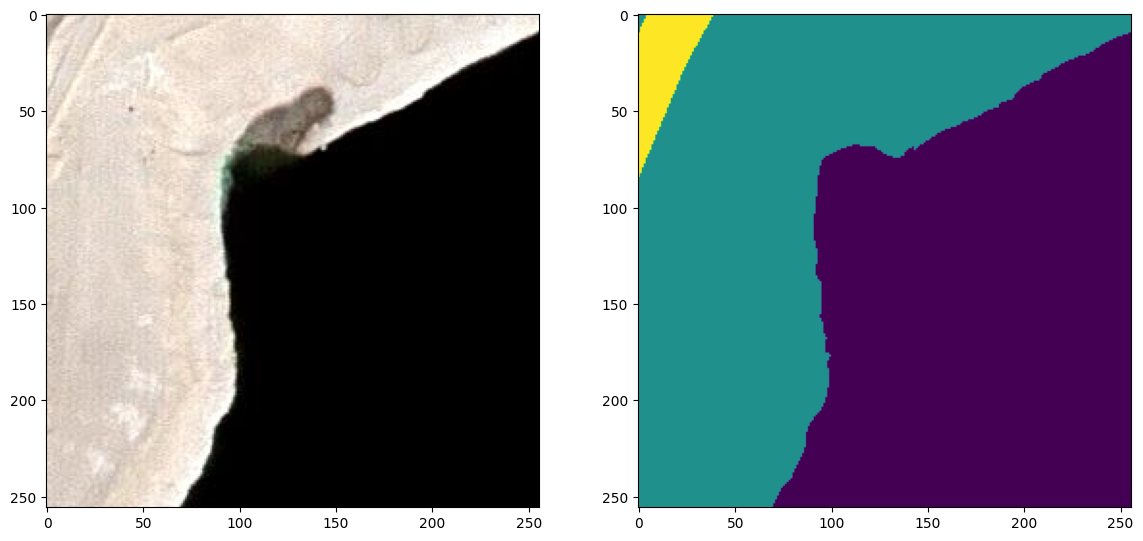

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:,:,0])

In [ ]:
total_classes = len(np.unique(labels))
total_classes

6

In [ ]:
# Convert single channel label mask -> categorical format suitable for training
from tensorflow.keras.utils import to_categorical
labels_categorical_dataset = to_categorical(labels, num_classes = total_classes)
labels_categorical_dataset.shape # 945 patches of size 256x256 with 6 classes

(945, 256, 256, 6)

In [ ]:
# Creating training and testing datasets
training_dataset = image_dataset
training_dataset.shape

(945, 256, 256, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_dataset, labels_categorical_dataset, test_size = 0.15, random_state = 100)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [ ]:
!pip install -U segmentation-models

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [ ]:
from keras import backend as K

In [ ]:
# Evaluation metrics -> Jaccard Index/IoU = Overlap/Union
def jaccard_coeff(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coeff_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coeff_value


In [ ]:
# the +1.0 above a small smoothing factor to avoid division by zero
# and stabilize the gradient during training

In [ ]:
# U-net Model Architecture
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):
  inputs = Input((image_height, image_width, image_channels))
  source_input = inputs
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9) # for classification, softmax is best activation
  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
# Set metrics
metrics = ['accuracy', jaccard_coeff]

In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=6 , image_height=256, image_width=256, image_channels=3)
model = get_deep_learning_model()

In [ ]:
# Loss function -> Focal Loss (Cross Entropy Loss Extension)
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
import segmentation_models as sm
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


Segmentation Models: using `keras` framework.


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
model_history = model.fit(X_train, y_train,batch_size=16, verbose=1,epochs=25,validation_data=(X_test, y_test),shuffle=False)

Epoch 1/25
51/51 [==============================] - 50s 361ms/step - loss: 1.0070 - accuracy: 0.4679 - jaccard_coeff: 0.2224 - val_loss: 0.9933 - val_accuracy: 0.5604 - val_jaccard_coeff: 0.2948
Epoch 2/25
51/51 [==============================] - 10s 201ms/step - loss: 0.9864 - accuracy: 0.6374 - jaccard_coeff: 0.3405 - val_loss: 0.9747 - val_accuracy: 0.6629 - val_jaccard_coeff: 0.4230
Epoch 3/25
51/51 [==============================] - 10s 205ms/step - loss: 0.9682 - accuracy: 0.7028 - jaccard_coeff: 0.4270 - val_loss: 0.9716 - val_accuracy: 0.6685 - val_jaccard_coeff: 0.4391
Epoch 4/25
51/51 [==============================] - 10s 202ms/step - loss: 0.9576 - accuracy: 0.7321 - jaccard_coeff: 0.4835 - val_loss: 0.9856 - val_accuracy: 0.6559 - val_jaccard_coeff: 0.4238
Epoch 5/25
51/51 [==============================] - 10s 203ms/step - loss: 0.9532 - accuracy: 0.7472 - jaccard_coeff: 0.5042 - val_loss: 0.9907 - val_accuracy: 0.6584 - val_jaccard_coeff: 0.4401
Epoch 6/25
51/51 [=======

In [ ]:
history_a = model_history

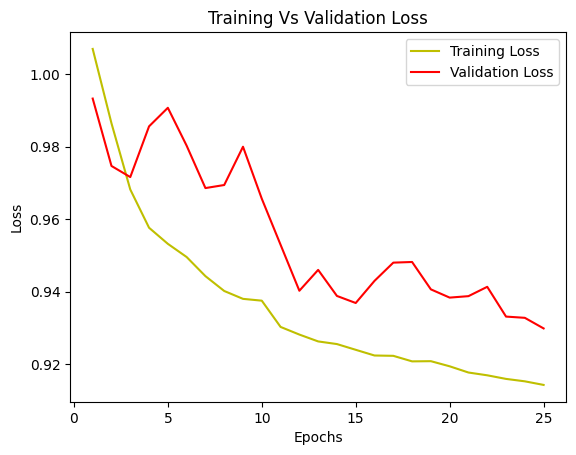

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

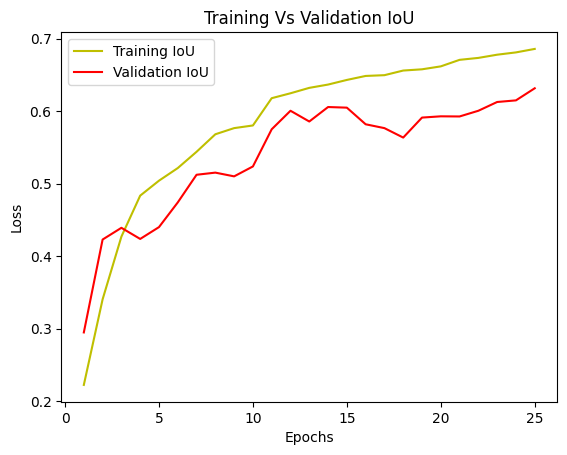

In [ ]:
jaccard_coeff = history_a.history['jaccard_coeff']
val_jaccard_coeff = history_a.history['val_jaccard_coeff']

epochs = range(1, len(jaccard_coeff) + 1)
plt.plot(epochs, jaccard_coeff, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coeff, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred

5/5 [==============================] - 5s 54ms/step


array([[[[4.38557044e-02, 4.12657648e-01, 1.78533524e-01,
          1.32969081e-01, 1.06197104e-01, 1.25786915e-01],
         [1.88555177e-02, 5.69260061e-01, 1.57984599e-01,
          9.83408988e-02, 9.63036194e-02, 5.92553280e-02],
         [1.42516764e-02, 5.90038240e-01, 1.64588898e-01,
          7.84446150e-02, 1.07965387e-01, 4.47111838e-02],
         ...,
         [3.91119756e-02, 3.55282754e-01, 2.22496271e-01,
          4.29631881e-02, 3.12827408e-01, 2.73183752e-02],
         [4.29807119e-02, 3.67179275e-01, 2.43085861e-01,
          4.28434461e-02, 2.65157491e-01, 3.87531705e-02],
         [7.38441423e-02, 2.74229258e-01, 2.77637631e-01,
          7.33109340e-02, 2.32261345e-01, 6.87167197e-02]],

        [[2.71081775e-02, 5.35929322e-01, 1.88794926e-01,
          9.16474909e-02, 8.96673724e-02, 6.68527931e-02],
         [7.21212244e-03, 7.29895711e-01, 1.27415612e-01,
          5.34865819e-02, 5.69638051e-02, 2.50261910e-02],
         [5.89269912e-03, 7.19754994e-01, 1.4405

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)
len(y_pred_argmax)

142

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)
len(y_test_argmax)

142

In [ ]:
# Comparing prediction results
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 22ms/step


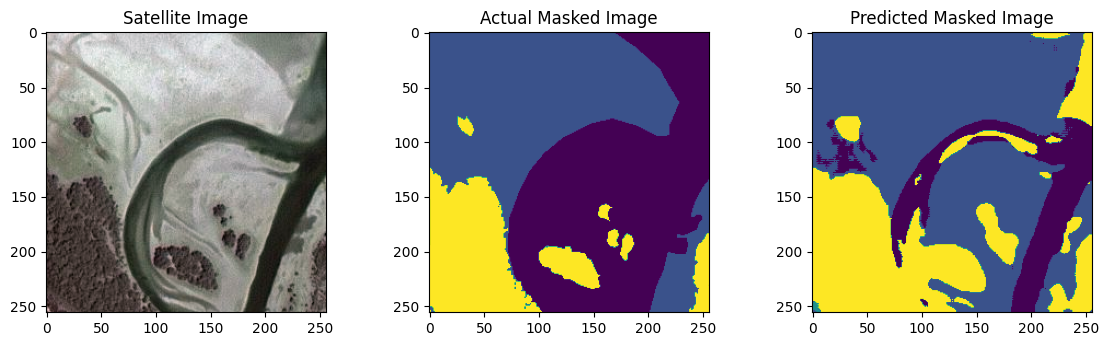

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Satellite Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Actual Masked Image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Masked Image")
plt.imshow(predicted_image)

In [ ]:
model.save('ISROv2-satelliteSeg.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
